<a href="https://colab.research.google.com/github/hoangnuthuphuong/MACHINE-LEARNING-TEST/blob/main/final_test1/preprocessing_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import numpy as np
import pandas as pd
import itertools
import pickle
import os
# Tiền xử lý dữ liệu ảnh
from PIL import Image
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# Huấn luyện mô hình
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
# Đánh giá mô hình
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
# Trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#HÀM KIỂM TRA ẢNH CÓ LỖI HAY KHÔNG
def check_corrupted_image(file):
    try:
        with Image.open(file) as img:
            img.verify()
            img_new = io.imread(os.path.join(file))
        return False
    except Exception as e:
        print(e)
        return True

def read_img_data(path, size):
    X = []
    y = []
    label = path.split ("\\")[-1]
    files = os.listdir(path)
    for img_file in files:
        if not check_corrupted_image(os.path.join(path,img_file)):
            img = io.imread(os.path.join(path, img_file), as_gray=True)
            img = resize(img, size)
            img_flatten = list(img.flatten())
            X.append(img_flatten)
            y.append(label)
    return X,y

def build_imd_data(folder_path, size):
    X = []
    y = []
    for img_folder in os.listdir(folder_path):
        X_temp, y_temp = read_img_data(os.path.join(folder_path, img_folder), size)
        X.extend(X_temp)
        y.extend(y_temp)
    return np.array(X), np.array(y)

# mã hóa nhãn lớp
def encode_label(y):
    lb = LabelBinarizer()
    return lb.fit_transform(y).reshape(y.shape[0], )

def count_unique_labels1(y):
    plt.title("CLASS LABEL BALANCE TEST", size=20, color="black")
    count_label = sns.countplot(y, label="Count", palette="muted", x="diagnosis")
    unique, counts = np.unique(y, return_counts = True)
    print('Cat: ', unique)
    print('Dog: ', counts)
    result = dict(zip(unique, counts))
    count_label.set_xticklabels(["Cat", "Dog",])
    print(result)

def count_unique_labels(y):
    unique, counts = np.unique(y, return_counts = True)
    result = dict(zip(unique, counts))
    return result




#Hàm huấn luyện mô hình
def kNN_grid_search_cv(X_train, y_train):
    from math import sqrt
    m = y_train.shape[0]
    k_max = int(sqrt(m)/2)
    k_values = np.arange(start = 1, stop = k_max + 1, dtype = int)
    params = { 'n_neighbors': k_values}
    kNN = KNeighborsClassifier()
    kNN_grid = GridSearchCV(kNN, params, cv=3)
    kNN_grid.fit(X_train, y_train)
    return kNN_grid

def logistic_regression_cv(X_train, y_train):
    logistic_classifier = LogisticRegressionCV(cv=5, solver="sag", max_iter=2000)
    logistic_classifier.fit(X_train, y_train)
    return logistic_classifier


#Hàm đánh giá mô hình
def evaluate_model(y_test, y_pred):
    print("accuracy score: ", accuracy_score(y_test, y_pred))
    print("Balandced accuracy score: ", balanced_accuracy_score(y_test, y_pred))
    print("Haming loss: ", hamming_loss(y_test, y_pred))

def evaluate_report(y_test, y_pred):
    print("Classification report:")
    print(classification_report(y_test, y_pred))




def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# vì ta đã xác định được từ đầu là bài toán phân lớp nhị phân nên ta dùng thang đo "binary"
def test_score(y_test, y_pred, class_type = "binary"):
    if class_type == "binary":
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        result = [accuracy, precision, recall, f1]
    return result

def test_table(knn_score, lg_score):
    result = {"Scores": ["accuracy", "precision", "recall", "f1"],
              "kNN": knn_score,"Logistic regression":lg_score}
    return pd.DataFrame(result)


def draw_precision_recall_curve(X_test, y_test, modal, name):
    no_modal = len(y_test [y_test == 1])/len(y_test)
    plt.plot([0,1], [no_modal, no_modal], linestyle = '--', label = 'No Skill')
    probs = modal.predict_proba(X_test) [:, 1]
    pre, rec, _ = precision_recall_curve(y_test, probs)
    plt.plot(pre, rec, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def draw_ROC(X_test, y_test, modal, name):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    probs = modal.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    # plt.plot(ns_probs, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def save_data(name,data):
    pickle_out = open(f"{name}.pickle", "wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()
def import_data(name):
    pickle_in = open(f"{name}.pickle", "rb")
    X = pickle.load(pickle_in)
    return x




cannot identify image file '/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở/final_test1/PetImages/Cat/Thumbs.db'
cannot identify image file '/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở/final_test1/PetImages/Cat/666.jpg'
'NoneType' object has no attribute 'ReadAsArray'
cannot identify image file '/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở/final_test1/PetImages/Dog/Thumbs.db'


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

cannot identify image file '/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở/final_test1/PetImages/Dog/11702.jpg'
{0: 12499, 1: 12499}
HUẤN LUYỆN MÔ HÌNH LOGISTIC REGRESSION
Kết quả dự đoán của mô hình logistic regression:
 [0 0 0 ... 0 0 0]

Confusion matrix, without normalization
[[2229 1442]
 [1749 2080]]


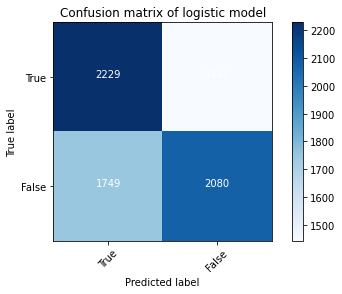


Đánh giá hiệu năng của mô hình logistic regression
accuracy score:  0.5745333333333333
Balandced accuracy score:  0.5752071372617706
Haming loss:  0.42546666666666666
Classification report:
              precision    recall  f1-score   support

           0       0.56      0.61      0.58      3671
           1       0.59      0.54      0.57      3829

    accuracy                           0.57      7500
   macro avg       0.58      0.58      0.57      7500
weighted avg       0.58      0.57      0.57      7500


	precision_recall_curve mô hình logistic


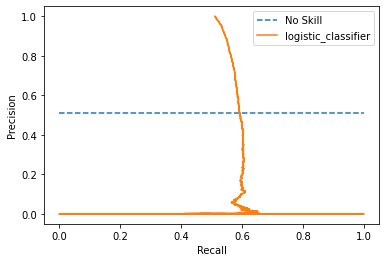


	ROC mô hình logistic_classifier


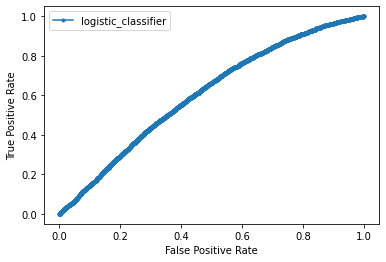



HUẤN LUYỆN MÔ HÌNH k-NN
Kết quả dự đoán của mô hình k lân cận:
 [1 0 0 ... 1 0 0]

Confusion matrix, without normalization
[[2030 1641]
 [1269 2560]]


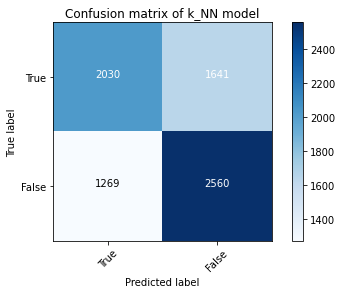


Đánh giá hiệu năng của mô hình k lân cận
accuracy score:  0.612
Balandced accuracy score:  0.610782356813431
Haming loss:  0.388
Classification report:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58      3671
           1       0.61      0.67      0.64      3829

    accuracy                           0.61      7500
   macro avg       0.61      0.61      0.61      7500
weighted avg       0.61      0.61      0.61      7500


	precision_recall_curve mô hình k-NN


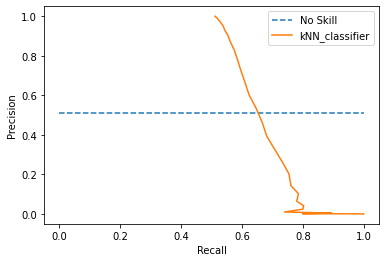


	ROC mô hình k-NN


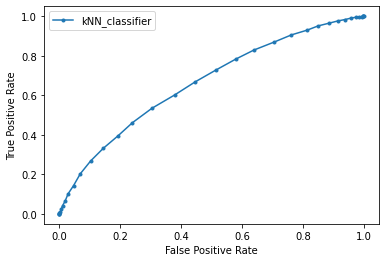

Cat:  [0 1]
Dog:  [12499 12499]
{0: 12499, 1: 12499}
None

Bảng so sánh hai mô hình logistic regression và k-NN
      Scores       kNN  Logistic regression
0   accuracy  0.612000             0.574533
1  precision  0.609379             0.590574
2     recall  0.668582             0.543223
3         f1  0.637609             0.565909


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


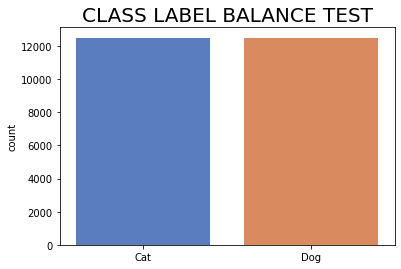

In [13]:
def main():
    # Đọc và xây dựng cơ sở dữ liệu
    data_dir = "/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở/final_test1/PetImages"
    X, y = build_imd_data(data_dir, size = (32,32))  
    save_data("X",X)
    save_data("y",y)

    # mã hoá nhãn lớp
    y = encode_label(y)
    print(count_unique_labels(y))

    # phân chia tập train và test
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle = True,
                                                        random_state = 15)

    print("HUẤN LUYỆN MÔ HÌNH LOGISTIC REGRESSION")
    logistic_classifier = logistic_regression_cv(X_train, y_train)
    # Lưu kết quả huấn luyện vào pickle
    save_data("logistic_classifier",logistic_classifier)
    y_pred_logistic = logistic_classifier.predict(X_test)
    print("Kết quả dự đoán của mô hình logistic regression:\n",y_pred_logistic)
    confusion = confusion_matrix(y_test, y_pred_logistic)
    plot_confusion_matrix(confusion, classes=['True', 'False'],
                          title='Confusion matrix of logistic model')
    print("\nĐánh giá hiệu năng của mô hình logistic regression")
    evaluate_model(y_test, y_pred_logistic)
    evaluate_report(y_test, y_pred_logistic)
    lg_score = test_score(y_test, y_pred_logistic)
    print("\n\tprecision_recall_curve mô hình logistic")
    draw_precision_recall_curve(X_test, y_test,logistic_classifier, "logistic_classifier")
    print("\n\tROC mô hình logistic_classifier")
    draw_ROC(X_test, y_test, logistic_classifier, "logistic_classifier")


    print("\n\nHUẤN LUYỆN MÔ HÌNH k-NN")
    kNN_classifier = kNN_grid_search_cv(X_train, y_train)
    # Lưu kết quả huấn luyện vào pickle
    save_data("kNN_classifier",kNN_classifier)
    y_pred_kNN = kNN_classifier.predict(X_test)
    print("Kết quả dự đoán của mô hình k lân cận:\n",y_pred_kNN)
    confusion = confusion_matrix(y_test, y_pred_kNN)
    plot_confusion_matrix(confusion, classes=['True', 'False'],
                          title='Confusion matrix of k_NN model')
    print("\nĐánh giá hiệu năng của mô hình k lân cận")
    evaluate_model(y_test, y_pred_kNN)
    evaluate_report(y_test, y_pred_kNN)
    knn_score = test_score(y_test, y_pred_kNN)
    print("\n\tprecision_recall_curve mô hình k-NN")
    draw_precision_recall_curve(X_test, y_test,kNN_classifier, "kNN_classifier")
    print("\n\tROC mô hình k-NN")
    draw_ROC(X_test, y_test,kNN_classifier, "kNN_classifier")
def main():
    # Đọc và xây dựng cơ sở dữ liệu
    data_dir = "/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở/final_test1/PetImages"
    X, y = build_imd_data(data_dir, size = (32,32))  
    save_data("X",X)
    save_data("y",y)

    # mã hoá nhãn lớp
    y = encode_label(y)
    print(count_unique_labels(y))

    # phân chia tập train và test
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle = True,
                                                        random_state = 15)

    print("HUẤN LUYỆN MÔ HÌNH LOGISTIC REGRESSION")
    logistic_classifier = logistic_regression_cv(X_train, y_train)
    # Lưu kết quả huấn luyện vào pickle
    save_data("logistic_classifier",logistic_classifier)
    y_pred_logistic = logistic_classifier.predict(X_test)
    print("Kết quả dự đoán của mô hình logistic regression:\n",y_pred_logistic)
    confusion = confusion_matrix(y_test, y_pred_logistic)
    plot_confusion_matrix(confusion, classes=['True', 'False'],
                          title='Confusion matrix of logistic model')
    print("\nĐánh giá hiệu năng của mô hình logistic regression")
    evaluate_model(y_test, y_pred_logistic)
    evaluate_report(y_test, y_pred_logistic)
    lg_score = test_score(y_test, y_pred_logistic)
    print("\n\tprecision_recall_curve mô hình logistic")
    draw_precision_recall_curve(X_test, y_test,logistic_classifier, "logistic_classifier")
    print("\n\tROC mô hình logistic_classifier")
    draw_ROC(X_test, y_test, logistic_classifier, "logistic_classifier")


    print("\n\nHUẤN LUYỆN MÔ HÌNH k-NN")
    kNN_classifier = kNN_grid_search_cv(X_train, y_train)
    # Lưu kết quả huấn luyện vào pickle
    save_data("kNN_classifier",kNN_classifier)
    y_pred_kNN = kNN_classifier.predict(X_test)
    print("Kết quả dự đoán của mô hình k lân cận:\n",y_pred_kNN)
    confusion = confusion_matrix(y_test, y_pred_kNN)
    plot_confusion_matrix(confusion, classes=['True', 'False'],
                          title='Confusion matrix of k_NN model')
    print("\nĐánh giá hiệu năng của mô hình k lân cận")
    evaluate_model(y_test, y_pred_kNN)
    evaluate_report(y_test, y_pred_kNN)
    knn_score = test_score(y_test, y_pred_kNN)
    print("\n\tprecision_recall_curve mô hình k-NN")
    draw_precision_recall_curve(X_test, y_test,kNN_classifier, "kNN_classifier")
    print("\n\tROC mô hình k-NN")
    draw_ROC(X_test, y_test,kNN_classifier, "kNN_classifier")

    print(count_unique_labels1(y))
    print("\nBảng so sánh hai mô hình logistic regression và k-NN")
    print(test_table(knn_score,lg_score))

if __name__ == '__main__':
    main()

    print(count_unique_labels1(y))
    print("\nBảng so sánh hai mô hình logistic regression và k-NN")
    print(test_table(knn_score,lg_score))

if __name__ == '__main__':
    main()
